## PART ONE

In [225]:
import numpy as np
import pandas as pd
import matplotlib as mp
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import GMM
from statsmodels.sandbox.regression.gmm import IV2SLS 
from scipy import stats

In [226]:
input_table = pd.read_csv('/Users/dylanbai/Desktop/Predictive Modeling/midterm_partone.csv')
input_table.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [227]:
model_iv = sm.OLS(input_table["Inventory Turnover"],input_table[["Constant","Current Ratio","Quick Ratio",\
                                                                 "Debt Asset Ratio"]]).fit()
endog_predict = model_iv.predict(input_table[["Constant","Current Ratio","Quick Ratio","Debt Asset Ratio"]])
input_table["Endogenous Param"] = endog_predict

In [228]:
model_2sls = sm.OLS(input_table["Stock Change"], input_table[["Constant","Endogenous Param",\
                                                              "Operating Profit","Interaction Effect",\
                                                             ]]).fit()
model_2sls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Stock Change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     8.530
Date:                Sat, 04 Nov 2023   Prob (F-statistic):           1.27e-05
Time:                        17:26:43   Log-Likelihood:                -1186.5
No. Observations:                1696   AIC:                             2381.
Df Residuals:                    1692   BIC:                             2403.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant              -0.0176      0.020     -0.896      0.370      -0.056       0.021
Endogenous Param       0.0011      0.001      1.827      0.068   -7.76e-05       0.002
Operating Profit      -0.1201      0.028     -4.319      0.000      -0.175      -0.066
Interaction Effect     0.0014      0.000      3.621      0.000       0.001       0.002
==============================================================================
Omnibus:                      368.832   Durbin-Watson:                   2.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3433.920
Skew:                           0.742   Prob(JB):                         0.00
Kurtosis:                       9.811   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [229]:
y_vals  = np.array(input_table["Stock Change"])
x_vals  = np.array(input_table[["Inventory Turnover","Operating Profit","Interaction Effect"]])
iv_vals = np.array(input_table[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

### We put the delta into params as well so we can see what imapct will be on the probility and to determine whether delta is significant or not.

In [230]:
class gmm(GMM):
    def momcond(self, params):
        p0, p1, p2, p3 ,delta= params  # Updated params including the 'delta'
        endog = self.endog
        exog = self.exog
        inst = self.instrument
        
       
        error0 = endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]
        error1 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,1]
        error2 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * exog[:,2]
        error3 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,0] -delta
        error4 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,1] -delta
        error5 = (endog - p0 - p1 * exog[:,0] - p2 * exog[:,1] - p3 * exog[:,2]) * inst[:,2] -delta

        g = np.column_stack((error0, error1, error2, error3, error4, error5))
        return g


beta0 = np.array([0.1, 0.1, 0.1, 0.1,0.1])
res = gmm(endog = y_vals, exog = x_vals, instrument = iv_vals, delta =0,k_moms=6, k_params=4).fit(beta0)

res.summary()



# calculate the delta's t-stats
t_stat_delta = res.params[4] / res.bse[4]
p_value_delta = 1 - stats.t.cdf(np.abs(t_stat_delta), res.nobs - 1)


print(f"Delta's t stats: {t_stat_delta}")
print(f"Delta's p value: {p_value_delta}")

# to determine whether the claim is statistically justified.
if p_value_delta < 0.05:  
    print("the industry expert’s claim is statistically justified !")
else:
    print("the industry expert’s claim is NOT statistically justified !")

Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 10
         Function evaluations: 15
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: 0.000345
         Iterations: 9
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.000346
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Delta's t stats: -0.2134062307025624
Delta's p value: 0.4155178928820831
the industry expert’s claim is NOT statistically justified !


## So from the information above, we can say the industry expert's claim is NOT statistically justified.

## PART TWO

In [231]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_curve, roc_auc_score, auc,precision_recall_curve, confusion_matrix, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

### Firstly, we can load the data and check the overall informations of the dataset.

In [232]:
df=pd.read_csv('/Users/dylanbai/Desktop/Predictive Modeling/midterm_parttwo.csv')

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Years of Education after High School  8081 non-null   int64 
 1   Requested Credit Amount               8081 non-null   object
 2   Number of Dependents                  8081 non-null   object
 3   Monthly Income                        8081 non-null   object
 4   Monthly Expense                       8081 non-null   object
 5   Marital Status                        8081 non-null   object
 6   Credit Rating                         8081 non-null   object
dtypes: int64(1), object(6)
memory usage: 442.1+ KB


In [234]:
df.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [235]:
df.describe()

,Years of Education after High School
count,8081.000000
mean,2.608588
std,1.571835
min,0.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,7.000000


### Since value of the following columns are all object so we need to transform them into numeric to process the further modeling steps. 

In [236]:
df['Number of Dependents'].unique()

array(['No dependent', 'Less than 2', 'More than 2'], dtype=object)

In [237]:
df['Monthly Income'].unique()

array(['Very low', 'Low', 'Moderate', 'High', 'Very High'], dtype=object)

In [238]:
df['Monthly Expense'].unique()

array(['Very low', 'Low', 'Moderate', 'High', 'Very high'], dtype=object)

In [239]:
df['Marital Status'].unique()

array(['Married', 'Single', 'Not specified'], dtype=object)

In [240]:
df['Requested Credit Amount'].unique()

array(['Low', 'Medium', 'High'], dtype=object)

In [241]:
df['Credit Rating'].unique()

array(['Positive', 'Negative'], dtype=object)

In [242]:
df['Credit Rating'] = df['Credit Rating'].replace({'Positive': 1, 'Negative': 0})
df['Number of Dependents'] = df['Number of Dependents'].replace({'No dependent':0, 'Less than 2':1, 'More than 2':2})
df['Requested Credit Amount'] = df['Requested Credit Amount'].replace({'Low':0, 'Medium':1, 'High':2})
df['Monthly Income'] = df['Monthly Income'].replace({'Very low':0, 'Low':1, 'Moderate':2, 'High':3, 'Very High':4})
df['Monthly Expense'] = df['Monthly Expense'].replace({'Very low':0, 'Low':1, 'Moderate':2, 'High':3, 'Very high':4})
df['Marital Status'] = df['Marital Status'].replace({'Married':2, 'Single':1, 'Not specified':0})


In [243]:
df.columns

Index(['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status', 'Credit Rating'],
      dtype='object')

### We divided the dataset equally into two as training and test sets and fit them into Logistic Regression model.

In [244]:
x = df[['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status']]
y = df['Credit Rating']

In [245]:
log = LogisticRegression()

In [246]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.5, random_state=1234)

In [247]:
num = ['Years of Education after High School', 'Requested Credit Amount',
       'Number of Dependents', 'Monthly Income', 'Monthly Expense',
       'Marital Status']

In [248]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num)
    ],
    remainder='passthrough')

# Fit the transformer using the training data
x_train_transformed = preprocessor.fit_transform(x_train)

In [249]:
x_test_transformed = preprocessor.fit_transform(x_test)

In [250]:
log.fit(x_train_transformed, y_train)

LogisticRegression()

In [251]:
pred_log = log.predict(x_test_transformed)

### then we print out the confusion matrix and recall, precision, and F1 score values

confusion matrix:


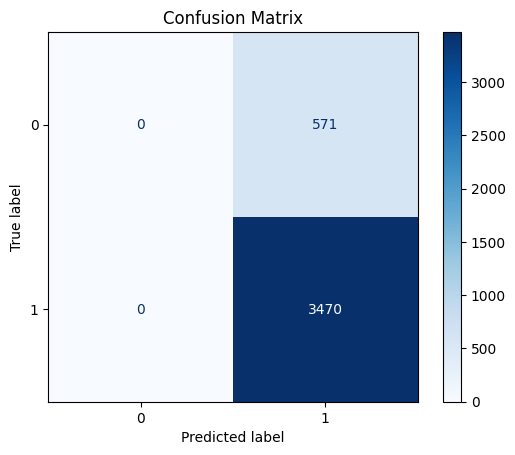

In [252]:
print(f"confusion matrix:")
cm = confusion_matrix(y_test, pred_log)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [253]:
print(f1_score(y_test,pred_log))
print(accuracy_score(y_test,pred_log))
print(recall_score(y_test,pred_log))
print(precision_score(y_test,pred_log))

0.9239781653574758
0.8586983419945559
1.0
0.8586983419945559


### To find the best threshold for a logistic regression model so that only 15% of the predictions are positive, we can use the ROC curve, which is a graphical representation of the true positive rate against the false positive rate for the different possible cutoffs of a diagnostic test. We can calculate the area under the ROC curve (AUC) and then find the threshold where the true positive rate corresponds to 15% (or the false positive rate corresponds to 85%).

In [254]:
y_pred_probs = log.predict_proba(x_test_transformed)[:, 1]

In [255]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

In [256]:
# Find the threshold where true positive rate corresponds to 15%
target_tpr = 0.15
best_threshold_idx = np.argmax(tpr >= target_tpr)

# Get the best threshold
best_threshold = thresholds[best_threshold_idx]

# Update predictions based on the best threshold
y_pred_thresholded = (y_pred_probs >= best_threshold).astype(int)


In [257]:
print(best_threshold)

0.8781244091079266


### Let's see the updated confusion matrix and recall, precision, and F1 score values.

In [258]:
print(f1_score(y_test,y_pred_thresholded))
print(accuracy_score(y_test,y_pred_thresholded))
print(recall_score(y_test,y_pred_thresholded))
print(precision_score(y_test,y_pred_thresholded))

0.25695299040118136
0.25290769611482306
0.15043227665706052
0.8802698145025295


confusion matrix:


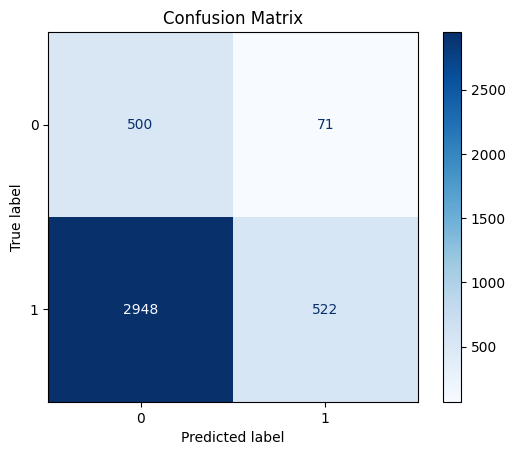

In [259]:
print(f"confusion matrix:")
cm = confusion_matrix(y_test, y_pred_thresholded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()